In [3]:
import pandas as pd 
import numpy as np
import pylab as plt 
import os
import json 

from collections import defaultdict

In [4]:
# "distortion": 1.0024048812562527,
# "frechet": 18.86473915385344,
# "directionality": 13.544692737430168,
# "monotonicity": 5.726256983240224,
# "projected_monotonicity": 0.0037938796748620504,
# "SL_angle": 0.5253465401656082,
# "mean_edge_length_difference": 2.2065501609141793,
# "inkratio": 0.9363746908612415,
# "mean_occupation_area": 28.519553072625698,
# "edge_density_distribution": 0.1843612641096115

metrics = ["distortion", "frechet", "directionality", "monotonicity", "projected_monotonicity", "mean_edge_length_difference", 
           "inkratio", "mean_occupation_area", "edge_density_distribution", "ambiguity_1", "precision_1", "specificity_1", "FPR_1", "all_crossings"]

In [5]:
#Gowalla_SF_5 is missing datapoints

In [6]:
outdir = "dashboard/output_dashboard"

graphmap = dict()
algmap   = dict() 

results = {metric: defaultdict(dict) for metric in metrics}
for graphname in os.listdir(outdir):
    if ".csv" in graphname: continue
    for alg in ['cubu', 'epb', 'fd', 'sepb', 'wr']:
        with open(f"{outdir}/{graphname}/{alg}.json") as fdata:
            jsdata = json.load(fdata)

        for metric in metrics:
            results[metric][graphname][alg] = jsdata['graph'][metric] if metric in jsdata['graph'] else -1



In [7]:
mdf = {metric: pd.DataFrame(res) for metric,res in results.items()}

In [8]:
mdf['distortion'].to_csv("out.csv")

In [10]:
arrdata = list()

for i, graph in enumerate(results['distortion'].keys()):
    graphmap[i] = graph
    for j, alg in enumerate(results['distortion'][graph].keys()):
        algmap[j] = alg
        arrdata.append([i,j])

        for metric in metrics:
            arrdata[-1].append(results[metric][graph][alg])

arr = np.array(arrdata)

In [11]:
from scipy.stats import spearmanr
correlations = dict()
for i in range(2,2+len(metrics)): 
    correlations[i] = dict()
    for j in range(2,i):

        x1 = arr[:,i]
        x2 = arr[:,j]

        fig, ax = plt.subplots()
        ax.scatter(x1,x2,c=arr[:,1])
        ax.set_title(f"{metrics[i-2]} - {metrics[j-2]}")

        fig.savefig(f"figures/scatterplots/{i}-{j}.png")
        plt.close(fig)

        ranks = spearmanr(x1,x2)
        correlations[i][j] = ranks.statistic

/tmp/ipykernel_8675/4084009121.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ranks = spearmanr(x1,x2)


In [12]:
np.max(arr[:,4])

np.float64(33.85793067226891)

In [13]:
from sklearn.preprocessing import RobustScaler

inp = RobustScaler().fit_transform(arr[:,2:])


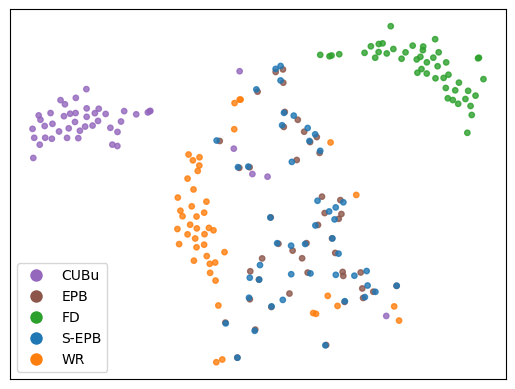

In [14]:
from sklearn.manifold import TSNE

X = TSNE(perplexity=30).fit_transform(inp)

colors = ["#9467bd", "#8c564b", "#2ca02c", "#1f77b4", "#ff7f0e", ]
c = [colors[int(i)] for i in arr[:,1]]

plt.scatter(X[:,0], X[:,1], c=c,s=15,alpha=0.8)
# Create legend handles

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10) for i in range(5)]
labmap = {
    "cubu": "CUBu", "epb": "EPB", "fd": "FD", "sepb": "S-EPB", 'wr': "WR"
}
labels = [labmap[algmap[i]] for i in range(5)]

# Add the legend
plt.legend(handles=handles, labels=labels,)

plt.xticks([])
plt.yticks([])

# plt.suptitle("t-SNE plot of bundle algorithms")
plt.savefig("figures/tsne.pdf")

In [15]:
overviewdata = list()
for i,row in enumerate(arr):
    gid = row[0]
    algid = row[1]
    metricvals = row[2:]
    overviewdata.append({
            'id': i, 
            'graph': graphmap[gid],
            'alg': algmap[algid],
        } | {metric: float(mval) for metric,mval in zip(metrics,metricvals)}
        | {'tsnex': float(X[i,0]), 'tsney': float(X[i,1])}
    )

In [16]:
import json 
with open("dashboard/overview.json", 'w') as fdata:
    json.dump(overviewdata,fdata,indent=4)

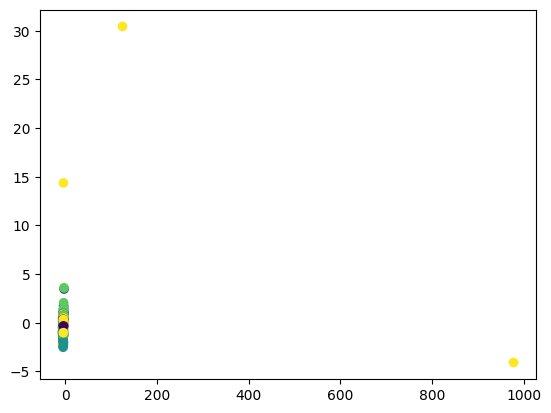

In [17]:
from sklearn.decomposition import PCA
X = PCA(2).fit_transform(inp)

plt.scatter(X[:,0], X[:,1], c=arr[:,1])

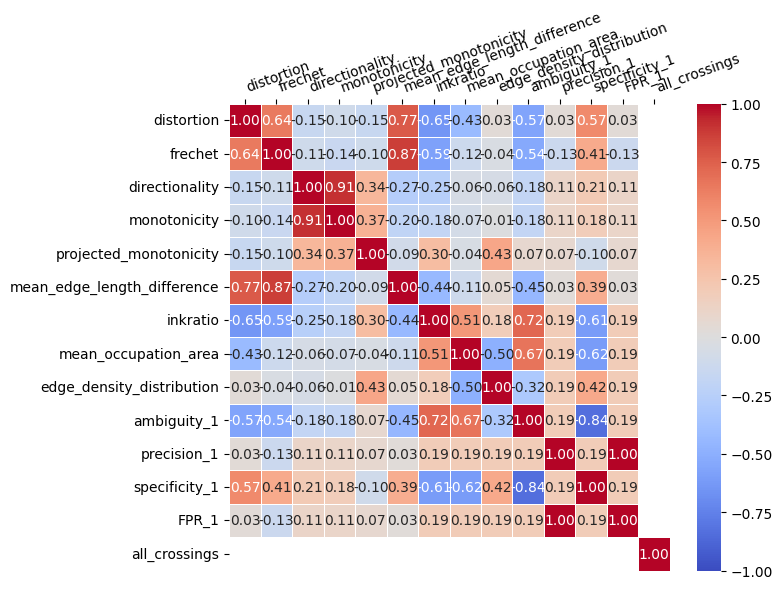

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = np.zeros((len(metrics), len(metrics)))
for i in correlations:
    for j in correlations[i]:
        correlation_matrix[i-2,j-2] = correlations[i][j]
        correlation_matrix[j-2,i-2] = correlations[i][j]

np.fill_diagonal(correlation_matrix,1.0)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=metrics, yticklabels=metrics, fmt=".2f", linewidths=0.5,
            vmin=-1,vmax=1)


# plt.yticks(rotation=45,ha='right')
plt.gca().xaxis.set_ticks_position('top')
plt.xticks(rotation=20,ha='left')

# Add title and show the plot
# plt.title('Correlation Heatmap of Objects')
plt.tight_layout()
plt.savefig("figures/correlations.pdf")

In [19]:
print(arr[25])

[ 5.00000000e+00  0.00000000e+00  1.16012762e+00  3.80195089e+01
  6.49260042e+00  3.29156256e+00  1.00238069e-02  3.20170759e+01
  6.29681773e-01  7.41687488e-01  2.07150206e-01  1.66801552e-01
  1.00000000e+00  9.75044563e-01  0.00000000e+00 -1.00000000e+00]


/tmp/ipykernel_8675/1917195497.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=labels, y=df[feature], palette="Set2")
/tmp/ipykernel_8675/1917195497.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=labels, y=df[feature], palette="Set2")
/tmp/ipykernel_8675/1917195497.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=labels, y=df[feature], palette="Set2")
/tmp/ipykernel_8675/1917195497.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` varia

ValueError: num must be an integer with 1 <= num <= 10, not 11

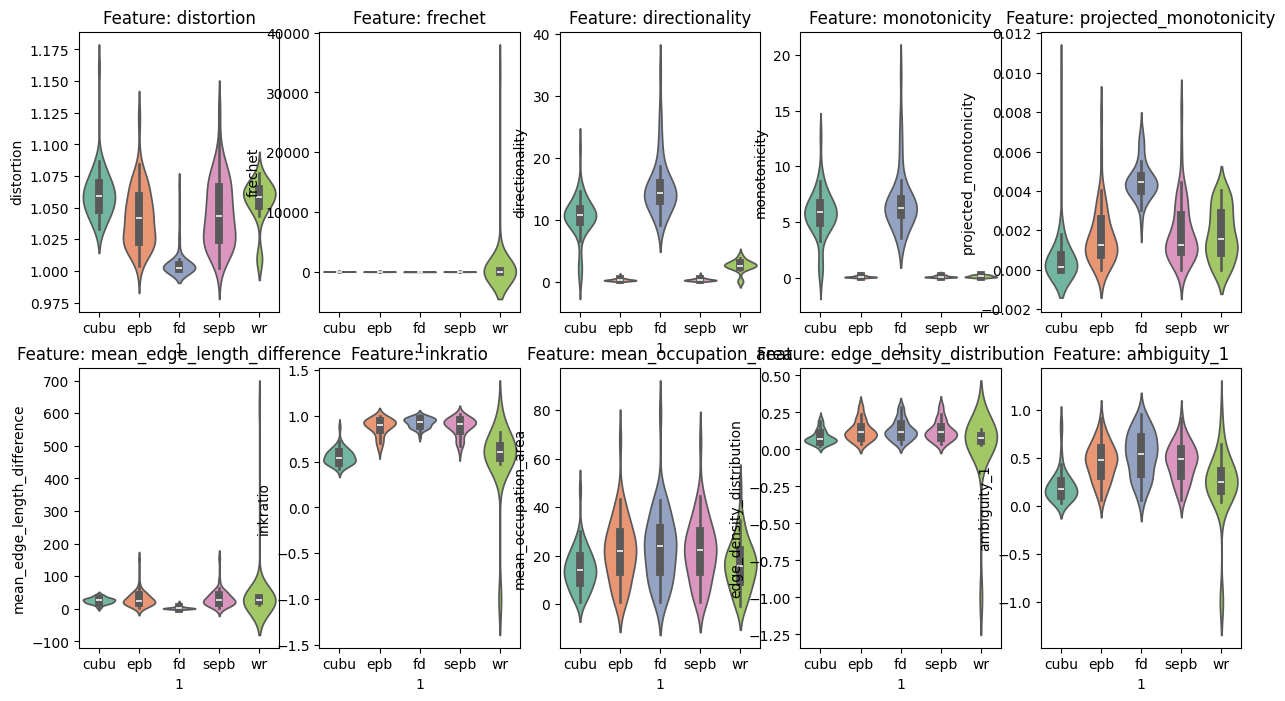

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_violin_charts(data):
    # Create a DataFrame from the array for easier handling
    df = pd.DataFrame(data)
    
    # Assuming the second column (index 1) is the label, and columns 2-11 are the features
    labels = df.iloc[:, 1]  # Labels from the second column
    features = df.iloc[:, 2:].columns  # Feature columns (from index 2 to the last column)
    
    # Set up the figure for plotting
    plt.figure(figsize=(15, 8))
    
    for idx, feature in enumerate(features):
        # Create a subplot for each feature
        plt.subplot(2, 5, idx + 1)  # Arrange as 2 rows and 5 columns
        
        # Create a violin plot for the current feature, grouped by the second column label
        sns.violinplot(x=labels, y=df[feature], palette="Set2")
        
        # Set title and axis labels
        plt.title(f"Feature: {metrics[idx]}")
        # plt.xlabel(f'Label (Second Column)')
        plt.xticks(ticks=range(5), labels=[algmap[i] for i in range(5)])
        plt.ylabel(f'{metrics[idx]}')
    
    # Adjust the layout to fit all plots
    plt.tight_layout()
    plt.savefig("figures/violins.pdf")

# Example usage:
# Assuming `data` is your n x 12 array
# data = np.array([...])  # Replace this with your actual data

plot_violin_charts(arr)